# Wavelength and oscillation period of MinDE patterns

*Jacob Kerssemakers, Sabrina Meindlhumer, Cees Dekker lab, 2022*

The flowing, semi-periodic patterns of MinDE pose some challenges to quantification.<br>
Here, we illustrate a systematic approach to extract global parameters, in particular the global wavelength $\mu$ and oscillation period $\tau$.<br>
<br>
**READ-ME:**<br>
Cells in this notebook need to be executed sequentially. Upon starting to explore this notebook, click the ▷▷ symbol above (*Restart the kernel, then re-run the whole notebook*) and hit "Restart" to ensure all required packages are loaded. After that, the notebook will take a few moments to set up, and figures/plots will re-appear one by one.<br>
At distinct positions in the notebook, the user is invited to change numeric input. After doing so, the notebook needs to be executed anew at least from this point on for changes to be applied.<br>
The notebook can be re-run from any given point onwards by clicking *Run* in the menu-bar above, and selecting *Run Selected Cell and All Below*. Alternatively, the ▷▷ symbol can be used again, which will re-run the notebook from the start. This will take a moment longer, but will have the same effect.

## Setup
Import of standard modules and assisting custom-made modules. Needs to be executed at least once to ensure correction functionality (see instructions above).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from min_analysis_tools import correlation_tools
from min_analysis_tools import get_data
from pathlib import Path

# Reload modules automatically before executing code
%reload_ext autoreload
%autoreload 2

## Select example
Choose one out of four possible provided example files in the list below:<br>
(1) "Simulated spiral"<br>
(2) "Min spiral (example data)"<br>
(3) "Min northwest-directed traveling waves (example data)"<br>
(4) "Min large stitched pattern (example data)"<br>
(5) "Min horizontally stitched pattern (example data)"<br>
<br>
Choose the example by setting "selection" in the code-box below. The notebook needs to be re-run (at least from the point onwards) for changes to be applied.

In [2]:
selection = 1  # default: 1

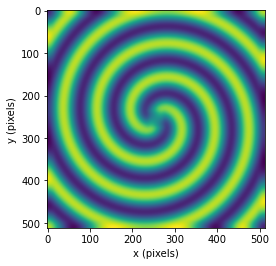

Current selection: 1


In [3]:
if selection > 5:
    print("Invalid selection. Set to selection 1 (Simulated spiral).")
    selection = 1
    MinDE_st = get_data.generate_pattern(
        lambda_t=10, lambda_x=1, size=512, N_frames=50, demo=False
    )
elif selection == 1:  # "Simulated spiral"
    MinDE_st = get_data.generate_pattern(
        lambda_t=10, lambda_x=1, size=512, N_frames=50, demo=False
    )
elif selection > 1:
    if selection == 2:  # "Min spiral (example data)"
        stack_path = Path().cwd() / "example_data" / "real_spiral.tif"
    if selection == 3:  # "Min northwest-directed traveling waves (example data)"
        stack_path = Path().cwd() / "example_data" / "real_northwest.tif"
    if selection == 4:  # "Min large stitched pattern (example data)"
        stack_path = Path().cwd() / "example_data" / "real_square_stitch.tif"
    if selection == 5:  # "Min horizontally stitched pattern (example data)"
        stack_path = Path().cwd() / "example_data" / "real_horizontal_stitch.tif"
    MinDE_st = get_data.load_stack(stack_path, size=None, demo=False)
nt, ny, nx = np.shape(MinDE_st)

fig, ax = plt.subplots()
ax.imshow(MinDE_st[0, :, :])
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.show()

print(f"Current selection: {selection}")

## Spatial autocorrelation
Spatial autocorrelation analysis is performed on a set number of images per movie. For each autocorrelation output image, a radial profile is recorded starting from the main central correlation peak. The resulting spatial radial correlation curves are subjected to maxima analysis. The first maximum after radius $R=0$ indicates the most predominant distance between wave edges, irrespective of propagation direction. This distance is identified as the pattern's global wavelength.<br>
First, we perform autocorrelation on a set number of frames of our loaded stack. For each analyzed frame, we obtain a correlation matrix such as the one below.<br>
You can change this number in the code-box below. The notebook needs to be re-run (at least from this point on) for changes to apply.

In [4]:
frames_to_analyse = 10  # integer number, default: 10

Analysing 10 frames


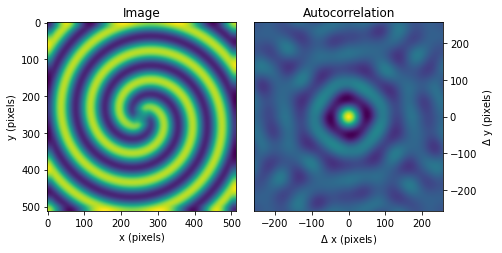

In [5]:
# calculate spatial autocorrelation maps for all analysed frames
(
    crmx_storage,
    fig,
    ax_corr,
    ax_orig,
) = correlation_tools.get_spatial_correlation_matrixes(
    MinDE_st, frames_to_analyse, demo=True
)

## Radial profile traces
Next, we perform radial averaging starting from the center peak. Ideally, we obtain a curve showing a clear first peak, indicating high correlation. We interpret this peak as representing the pattern's predominant, "global" wavelength $\mu$.<br>

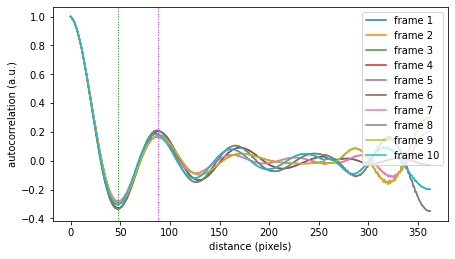

In [6]:
# calculate radially averaged profile traces and analyze them with respect to first min and max
(
    min_pos,
    min_val,
    max_pos,
    max_val,
    peak_valley_diff,
    fig,
    ax,
) = correlation_tools.analyze_radial_profiles(crmx_storage, demo=True)

Wavelengths obtained from all analysed frames can be averaged:

In [7]:
# output characteristic parameters
print(f"Mean position of first valley: {np.mean(min_pos):.02f}")
print(f"Mean position of first peak: {np.mean(max_pos):.02f} (wavelength in pixels)")
print(f"Mean peak-valley difference: {np.mean(peak_valley_diff):.02f}")

Mean position of first valley: 47.80
Mean position of first peak: 87.60 (wavelength in pixels)
Mean peak-valley difference: 0.49


## Temporal autocorrelation
For temporal correlation, we generate a set of $t$-$x$ or $t$-$y$ kymographs per movie, evenly distributed over a set middle fraction fraction of an image. For each set of kymographs, autocorrelation analysis is performed. The $\Delta x$=0 or $\Delta y$=0 line of the resulting autocorrelation maps then in effect represent a temporal correlation curve averaged over all the original image points on this line. In other words, they represent average temporal correlation signals sampled from all selected surface locations.<br>
Analogous to the spatial correlation analysis, the first maximum after  $\Delta t=0$ indicates a main oscillation period.<br>
<br>
We start by reslicing our images in $x$- or $y$-direction. Note that one frame in such a stack then corresponds to one horizontal or vertical cross-section in the original imaged region, meaning that the frames in our stack are comprised of kymographs of all points along this line.

In [8]:
# reslice frames
MinDE_shift_tx = np.moveaxis(MinDE_st, 0, -1)  # creates t-x resliced frames
MinDE_shift_yt = np.moveaxis(MinDE_st, -1, 0)  # creates y-t resliced frames

# next transpose y-t slices to have t axis in 1st dimension
MinDE_shift_ty = np.empty((nx, ny, nt))
for frame in range(nx):
    MinDE_shift_ty[frame, :, :] = np.transpose(MinDE_shift_yt[frame, :, :])

Using these resliced stacks makes it easier to access the temporal information within our data. We will now perform autocorrelation for selected frames of our resliced stacks, corresponding to cross sections along the $x$- or $y$-axis along our original images as shown above. The $x$- and $y$-positions of these lines are determined by the two parameters *reps_per_kymostack* and *kymoband*.<br>
These input numbers can be changed in the code-box below. The notebook needs to be re-run (at least from this point on) for changes to apply.

In [9]:
reps_per_kymostack = 5  # pick ... kymographs around middle (integer number, default: 5)
kymoband = 0.8  # analyse middle ... part of image (< 1, default: 0.8)

Below, the colored lines indicate all cross-sections for constant $y$ along which autocorrelation is performed, each corresponding to one particular frame in the $t$-$x$ resliced stack.<br>
The thick, red lines highlights the first horizontal cross-section at constant $y$, for which the exemplary $t$-$x$ slice and its autocorrelation map are shown.<br>
Note that the slice is comprised of a series of kymographs for all $x$ positions along that particular constant $y$.

Current reps_per_kymostack: 5
Current kymoband: 0.8


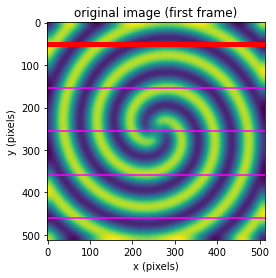

In [10]:
print(f"Current reps_per_kymostack: {reps_per_kymostack}")
print(f"Current kymoband: {kymoband}")

slices2analyze_x = ny * np.linspace(
    0.5 - kymoband / 2, 0.5 + kymoband / 2, reps_per_kymostack
)
slices2analyze_x = slices2analyze_x.astype(int)

fig, ax = plt.subplots(1, 1)
ax.imshow(MinDE_st[0, :, :])
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_title("original image (first frame)")
for num_y, y_axis in enumerate(slices2analyze_x):
    if num_y == 0:
        ax.axhline(y=y_axis, color="red", linewidth=5)
    else:
        ax.axhline(y=y_axis, color="magenta")

Analyzing t-x slices for y = [ 51 153 256 358 460]


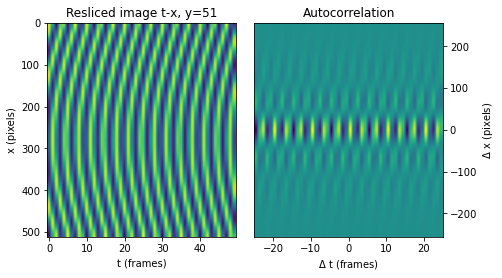

In [11]:
selection_reslice_x = f"{selection}_x_resliced"
(
    crmx_storage_x,
    slices2analyze,
    fig,
    ax_corr,
    ax_orig,
) = correlation_tools.get_temporal_correlation_matrixes(
    MinDE_shift_tx,
    "x",
    kymoband,
    reps_per_kymostack,
    demo=True,
)

The $\Delta x = 0$ line of these autocorrelation maps then in effect represents a temporal correlation curve averaged over all the original image points along this cross-section at constant $y$.<br>
Analogous to the spatial correlation analysis, the first maximum after $\Delta t = 0$ indicates a main oscillation period.

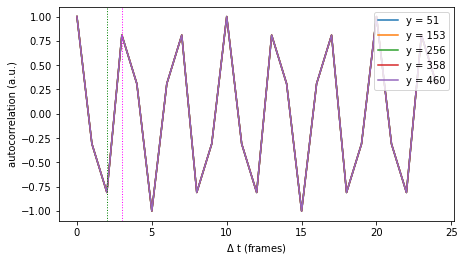

In [12]:
# analyse selected traces with respect to first min and max
(
    first_min_pos_x,
    first_min_val_x,
    first_max_pos_x,
    first_max_val_x,
    peak_valley_diff_x,
    fig,
    ax,
) = correlation_tools.analyze_temporal_profiles(
    "x", crmx_storage_x, slices2analyze_x, demo=True
)

The same analysis pipeline can be performed for cross-sections at constant $x$. Below, the colored lines indicate all cross-sections for constant $x$ along which autocorrelation is performed, each corresponding to one particular frame in the $t$-$y$ resliced stack.<br>
The thick, red lines highlights the first horizontal cross-section at constant $x$, for which the exemplary $t$-$y$ slice and its autocorrelation map are shown.<br>
Again, note that the slice is comprised of a series of kymographs for all $y$ positions along that particular constant $x$.

Current reps_per_kymostack: 5
Current kymoband: 0.8


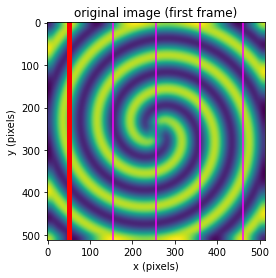

In [13]:
print(f"Current reps_per_kymostack: {reps_per_kymostack}")
print(f"Current kymoband: {kymoband}")

slices2analyze_y = nx * np.linspace(
    0.5 - kymoband / 2, 0.5 + kymoband / 2, reps_per_kymostack
)
slices2analyze_y = slices2analyze_y.astype(int)

fig, ax = plt.subplots(1, 1)
ax.imshow(MinDE_st[0, :, :])
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_title("original image (first frame)")
for num_x, x_axis in enumerate(slices2analyze_y):
    if num_x == 0:
        ax.axvline(x=x_axis, color="red", linewidth=5)
    else:
        ax.axvline(x=x_axis, color="magenta")

Analyzing t-y slices for x = [ 51 153 256 358 460]


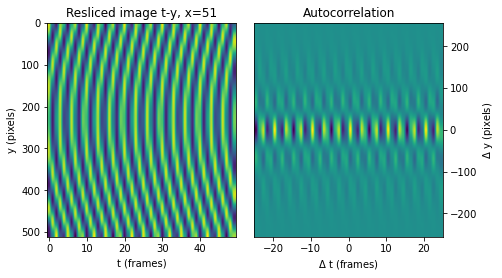

In [14]:
selection_reslice_y = f"{selection}_y_resliced"
(
    crmx_storage_y,
    slices2analyze_y,
    fig,
    ax_corr,
    ax_orig,
) = correlation_tools.get_temporal_correlation_matrixes(
    MinDE_shift_ty,
    "y",
    kymoband,
    reps_per_kymostack,
    demo=True,
)

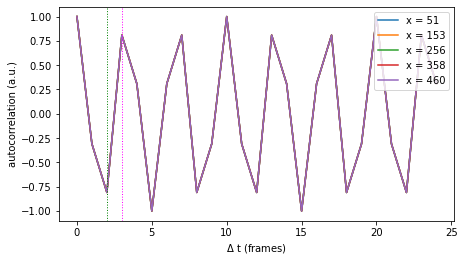

In [15]:
(
    first_min_pos_y,
    first_min_val_y,
    first_max_pos_y,
    first_max_val_y,
    peak_valley_diff_y,
    fig,
    ax,
) = correlation_tools.analyze_temporal_profiles(
    "y", crmx_storage_y, slices2analyze_y, demo=True
)

Finally, the parameters collected from all used slices can be averaged to identify the predominant, "global" oscillation period $\tau$ of the pattern:

In [16]:
# output characteristic parameters
print(
    f"Mean position of first valley: {np.mean(np.append(first_min_pos_x, first_min_pos_y)):.02f}"
)
print(
    f"Mean position of first peak: {np.mean(np.append(first_max_pos_x, first_max_pos_y)):.02f} (oscillation period in time/frame)"
)
print(
    f"Mean peak-valley difference: {np.mean(np.append(peak_valley_diff_x, peak_valley_diff_y)):.02f}"
)

Mean position of first valley: 2.00
Mean position of first peak: 3.00 (oscillation period in time/frame)
Mean peak-valley difference: 1.62
